<h1> MULTINOMIAL NAIVE BAYES IMPLEMENTATION <h1>

<h2> IMPORTS <h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cupy as cp
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


<h2> IMPORTS AND SPLIT <h2>

In [2]:
import os
os.chdir(r"C:\Users\Salaar Masood\OneDrive - Higher Education Commission\ML (CS438)\Proj\Progress\Urdu-News-Classification") # change to whatever your dir is
path = r"dataset/cleaned_articles/cleaned_articles_without_numbers_v2.csv"
data = pd.read_csv(path)

In [3]:
X = data['content']
Y = data['gold_label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=501)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


category_to_label = {
    "entertainment": 0,
    "business": 1,
    "sports": 2,
    "science-technology": 3,
    "international": 4
}

Y_train = [category_to_label[label.strip()] for label in Y_train if label.strip() in category_to_label]
Y_test = [category_to_label[label.strip()] for label in Y_test if label.strip() in category_to_label]


X_train shape: (2000,)
X_test shape: (501,)
Y_train shape: (2000,)
Y_test shape: (501,)


<h2> BAG OF WORDS <h2>

In [4]:
class TextProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.vocabulary = {}

    def build_vocabulary(self):
        unique_words = set()
        for sentence in self.dataset:
            unique_words.update(sentence.split())
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(unique_words))}
        return self.vocabulary

    def sentence_to_bow(self, sentence):
        words = sentence.split()
        vector = np.zeros(len(self.vocabulary))
        for word in words:
            if word in self.vocabulary:
                index = self.vocabulary[word]
                # print(index)
                vector[index] += 1
        return vector

    def vectorize_sentences(self, X):
        return [self.sentence_to_bow(sentence) for sentence in X]


In [5]:
bag = TextProcessor(X_train)
vocab = bag.build_vocabulary()
train_x = bag.vectorize_sentences(X_train)
test_x = bag.vectorize_sentences(X_test)
# print("trainx", train_x[0][12242])
# print(vocab)

<h2> IMPLEMENTATION <h2>

In [ ]:
#NumPy arrays
train_x = np.array(train_x)
test_x = np.array(test_x)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

class NaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha 

    def train(self, X_train, y_train):
        """
        Train the Naive Bayes classifier.
        X_train: Matrix of shape (n_samples, n_features), binary or count data.
        y_train: Array of shape (n_samples,), class labels for the training data.
        """
        n_samples, n_features = X_train.shape
        self.classes = np.unique(y_train)  
        n_classes = len(self.classes)
        
        self.log_prior = np.zeros(n_classes)  # log priors P(c)
        self.log_likelihood = np.zeros((n_classes, n_features))  # log likelihoods P(w | c)
        
        for idx, c in enumerate(self.classes):
            X_c = X_train[y_train == c]
            self.log_prior[idx] = np.log(X_c.shape[0]) - np.log(n_samples)
            
            word_counts = X_c.sum(axis=0)  # count occurrences of each word in class c
            total_count = word_counts.sum()  # total words in documents of class c
            
            # laplace smoothing
            self.log_likelihood[idx, :] = np.log(word_counts + self.alpha) - np.log(total_count + self.alpha * n_features)

    def predict(self, X_test):
        """
        Predict the class labels for test data.
        X_test: Matrix of shape (n_samples, n_features), binary or count data.
        """
        n_samples = X_test.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))  # store log probabilities for each class
        
        for idx in range(n_classes):
            log_probs[:, idx] = X_test @ self.log_likelihood[idx, :] + self.log_prior[idx]
        
        return self.classes[np.argmax(log_probs, axis=1)]

nb = NaiveBayes(alpha=0.09)
nb.train(train_x, Y_train)

y_pred_train = nb.predict(train_x)
y_pred_test = nb.predict(test_x)

def confusion_matrix(y_true, y_pred, labels):
    n_classes = len(labels)
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        if t in label_to_index and p in label_to_index:
            i = label_to_index[t]
            j = label_to_index[p]
            conf_matrix[i, j] += 1
    return conf_matrix

def precision_recall_f1(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp
    fn = np.sum(conf_matrix, axis=1) - tp
    
    # epsilon is used to avoid division by zero
    epsilon = 1e-10
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    return precision, recall, f1

labels = np.unique(Y_train)
conf_matrix = confusion_matrix(Y_test, y_pred_test, labels)
print("Confusion Matrix:")
print(conf_matrix)

precision, recall, f1 = precision_recall_f1(conf_matrix)
support = np.sum(conf_matrix, axis=1)

weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1 = np.sum(f1 * support) / np.sum(support)

print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1 Score: {weighted_f1:.2f}")

for idx, label in enumerate(labels):
    print(f"Class {label}: Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}, F1 Score={f1[idx]:.2f}, Support={support[idx]}")

train_accuracy = np.mean(y_pred_train == Y_train)
test_accuracy = np.mean(y_pred_test == Y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Confusion Matrix:
[[105   1   0   1   0]
 [  0  92   0   2   1]
 [  1   0  83   0   1]
 [  1   0   0 103   0]
 [  1   0   0   1 108]]
Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1 Score: 0.98
Class 0: Precision=0.97, Recall=0.98, F1 Score=0.98, Support=107
Class 1: Precision=0.99, Recall=0.97, F1 Score=0.98, Support=95
Class 2: Precision=1.00, Recall=0.98, F1 Score=0.99, Support=85
Class 3: Precision=0.96, Recall=0.99, F1 Score=0.98, Support=104
Class 4: Precision=0.98, Recall=0.98, F1 Score=0.98, Support=110
Training Accuracy: 0.9830
Test Accuracy: 0.9800


<h2> Plotting heatmap <h2>

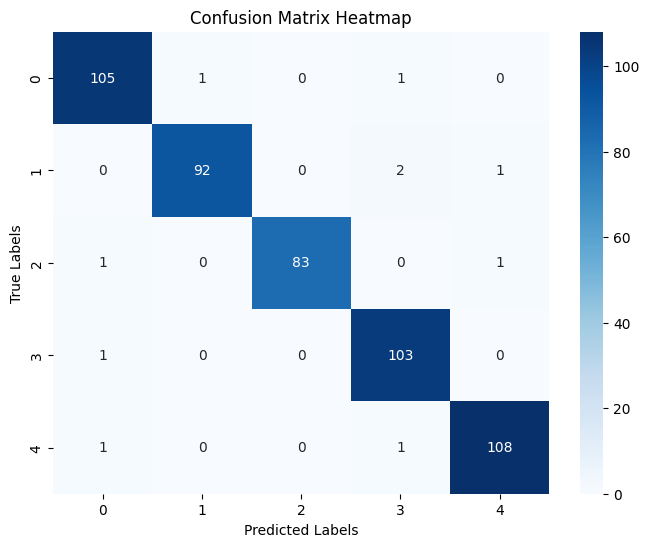

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()